In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.misc import imread, imsave, imresize
from scipy import ndimage
import os
import pickle
import re
from skimage import draw, data
import copy
import PIL.Image as Image
import cv2

## 调参

In [2]:
def read_file(depth_name):
    with open(depth_name) as f:
        df = pd.read_csv(f, names = ['x', 'z', 'y'], sep=' ')
    df.z = df.z - 170
    df = df[df.z > 0]
    df.x = df.x - 30
    df.y = df.y - 100
    df['a'] = np.arctan(df.x / df.z)/np.pi*180     #左右
    df['b'] = np.arctan(df.y / df.z)/np.pi*180     #上下
    df['d'] = np.sqrt(df.x ** 2 + df.y ** 2 + df.z ** 2)
    return df

def set_position(df, shape, min_a, max_a, min_b, max_b):
    df = df[df.b.map(lambda t: min_b < t < max_b)]        #上下
    df = df[df.a.map(lambda t: min_a < t < max_a)]  # select points to meet the conditions    #左右
    
    df['i'] = shape[0]-1 - np.around( (df.b-min_b) / (max_b-min_b) * (shape[0] - 1))  # rounding the position
    df['j'] = np.around( (df.a-np.min(df.a)) / (np.max(df.a)-np.min(df.a)) * (shape[1]-1) ) #左右
    return df

def get_depth(df, shape):
    depth = np.zeros(shape, np.float32)
    grouped = df.groupby(['i', 'j'], sort=False, as_index=False).mean()
    for var in grouped.values:
        depth[int(var[0]), int(var[1])] = var[7]/100
    return depth
def _fuse_image_depth(image, depth, channel=2):
    fuse = np.ndarray(image.shape)
    #depth.dtype = image.dtype
    fuse[:,:,channel] = image[:,:,channel]
    fuse[:,:,1] = depth[:,:]
    return fuse
def _crop_image(original_image, up, down, left, right):
    crop_image = copy.deepcopy(original_image[up:down, left:right])
    return crop_image
def paintXYaxes(h, v, color='r', extend=3):
    x = np.linspace(v-extend,v+extend)
    y = h*np.ones(x.shape, dtype=x.dtype)  # plot horizontal axes
    plt.plot(x,y,color)
    y = np.linspace(h-extend,h+extend)
    x = v*np.ones(y.shape, dtype=y.dtype)  # plot vertical axes
    plt.plot(x,y,color)
    
def paintBox(up, down, left, right, color='r'):
    north_x = np.linspace(left, right)    
    north_y = up * np.ones_like(north_x)
    plt.plot(north_x, north_y, color)    #  plot horizontal up
    south_x = np.linspace(left, right)
    south_y = down * np.ones_like(north_x)
    plt.plot(south_x, south_y, color)   #  plot horizontal down
    
    west_y = np.linspace(up, down)
    west_x = left * np.ones_like(south_y)
    plt.plot(west_x, west_y, color)    #  plot vertical left
    east_y = np.linspace(up, down)
    east_x = right * np.ones_like(east_y)
    plt.plot(east_x, east_y, color)
    #  plot vertical right


In [3]:
pc_dir='D:/data2/txt/water/'       #  point cloud 
pc_filename_list=os.listdir(pc_dir)
pc_path = [os.path.join(pc_dir, name) for name in pc_filename_list]

rgb_dir='D:/data2/rgb/water/'      # rgb image
rgb_filename_list=os.listdir(rgb_dir)
rgb_path = [os.path.join(rgb_dir, name) for name in rgb_filename_list]

ir_dir =  'D:/data2/ir/water/'    # infraded image
ir_filename_list = os.listdir(ir_dir)
ir_path = [os.path.join(ir_dir, name) for name in ir_filename_list]

In [4]:
pc_lenth = len(pc_filename_list)
print(pc_lenth)

436


In [5]:
print('Start frame: ' + pc_filename_list[0] + ' -----> ' + 'End frame: ' + pc_filename_list[-1])

Start frame: 3D64_0000100000.txt -----> End frame: 3D64_0000102382.txt


In [155]:
def final_depth(ir_path, rgb_path, pc_path): 
    shape = (480,640)
    
    ir= imread(ir_path)
    ir = ir[36:-36, 36:-36]  # 截掉黑色边框
    ir = ndimage.rotate(ir, 180) # 翻转图像
    res_ir = imresize(ir,shape)
    
    rgb = imread(rgb_path)
    res_rgb = imresize(rgb, shape)
    
    df = read_file(pc_path)
    df1 = set_position(df, shape, min_a=-45, max_a=45, min_b=-30, max_b=30)
    depth = get_depth(df1, shape)
    
    #--------------------------fitting box-------------------------#
    up1, down1, left1, right1 = 125, 350, 100, 420   # crop box ir        200, 479, 35, 639
    box_ir = (up1, down1, left1, right1)
    crop_ir = _crop_image(res_ir, up1, down1, left1, right1) 
    temp_ir = Image.fromarray(crop_ir)  
    resized_ir = temp_ir.resize((512,256), Image.ANTIALIAS)  # resize
    finished_ir = np.array(resized_ir)

    up2, down2, left2, right2 = 150, 300, 188, 400   # crop box rgb   
    box_rgb = (up2, down2, left2, right2)
    crop_rgb = _crop_image(res_rgb, up2, down2, left2, right2) 
    temp_rgb = Image.fromarray(crop_rgb)  
    resized_rgb = temp_rgb.resize((512,256), Image.ANTIALIAS)  # resize
    finished_rgb = np.array(resized_rgb)
    
    up3, down3, left3, right3 = 220, 320, 160, 380  # crop box depth 
    box_depth = (up3, down3, left3, right3)
    crop_depth = _crop_image(depth, up3, down3, left3, right3)
    temp_depth = Image.fromarray(crop_depth)
    resized_depth = temp_depth.resize((512,256))    # 一定要用PIL.Image库中的resize，filter为nearest，不会改变深度值
    finished_depth = np.array(resized_depth)
    
    return finished_ir, finished_rgb, finished_depth, res_ir, res_rgb, depth, box_ir, box_rgb, box_depth

index = 150     # 740    # 生成的个别图片有问题，比如266,why? 
print(ir_path[index])
print(rgb_path[index])
print(pc_path[index])
finished_ir, finished_rgb, finished_depth, res_ir, res_rgb, depth, box_ir, box_rgb, box_depth= final_depth(ir_path[index], rgb_path[index], pc_path[index])
#fuse_ir = _fuse_image_depth(finished_ir, finished_depth, 1)

D:/data2/ir/water/ImageL0000100838.jpg
D:/data2/rgb/water/2D-00100838.jpg
D:/data2/txt/water/3D64_0000100838.txt


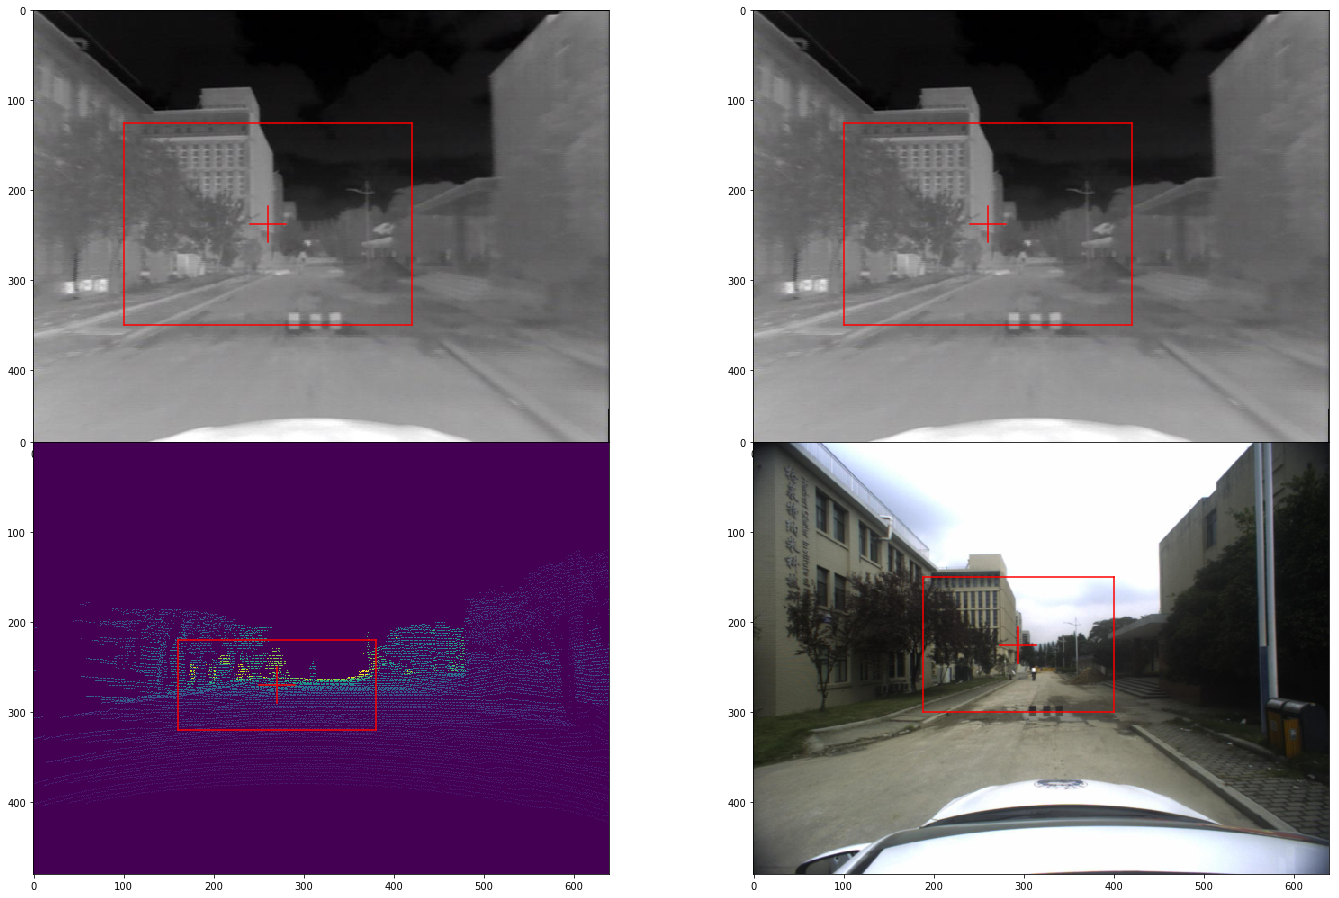

In [156]:
up1, down1, left1, right1 = box_ir
up2, down2, left2, right2 = box_rgb
up3, down3, left3, right3 = box_depth

plt.figure(figsize=(40,20))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.6, top=0.8, hspace=0, wspace=0)

plt.subplot(221)     # ir
paintBox(up1, down1, left1, right1)
paintXYaxes((down1+up1)//2, (right1+left1)//2, extend=20)
plt.imshow(res_ir)
plt.subplot(222)     # ir
paintBox(up1, down1, left1, right1)
paintXYaxes((down1+up1)//2, (right1+left1)//2, extend=20)
plt.imshow(res_ir)

plt.subplot(223)    # depth
paintBox(up3, down3, left3, right3)
paintXYaxes((up3+down3)//2, (left3+right3)//2, extend=20)
plt.imshow(depth)
plt.subplot(224)    # rgb
paintBox(up2, down2, left2, right2)
paintXYaxes((up2+down2)//2, (left2+right2)//2, extend=20)
plt.imshow(res_rgb)
plt.show()

plt.show()

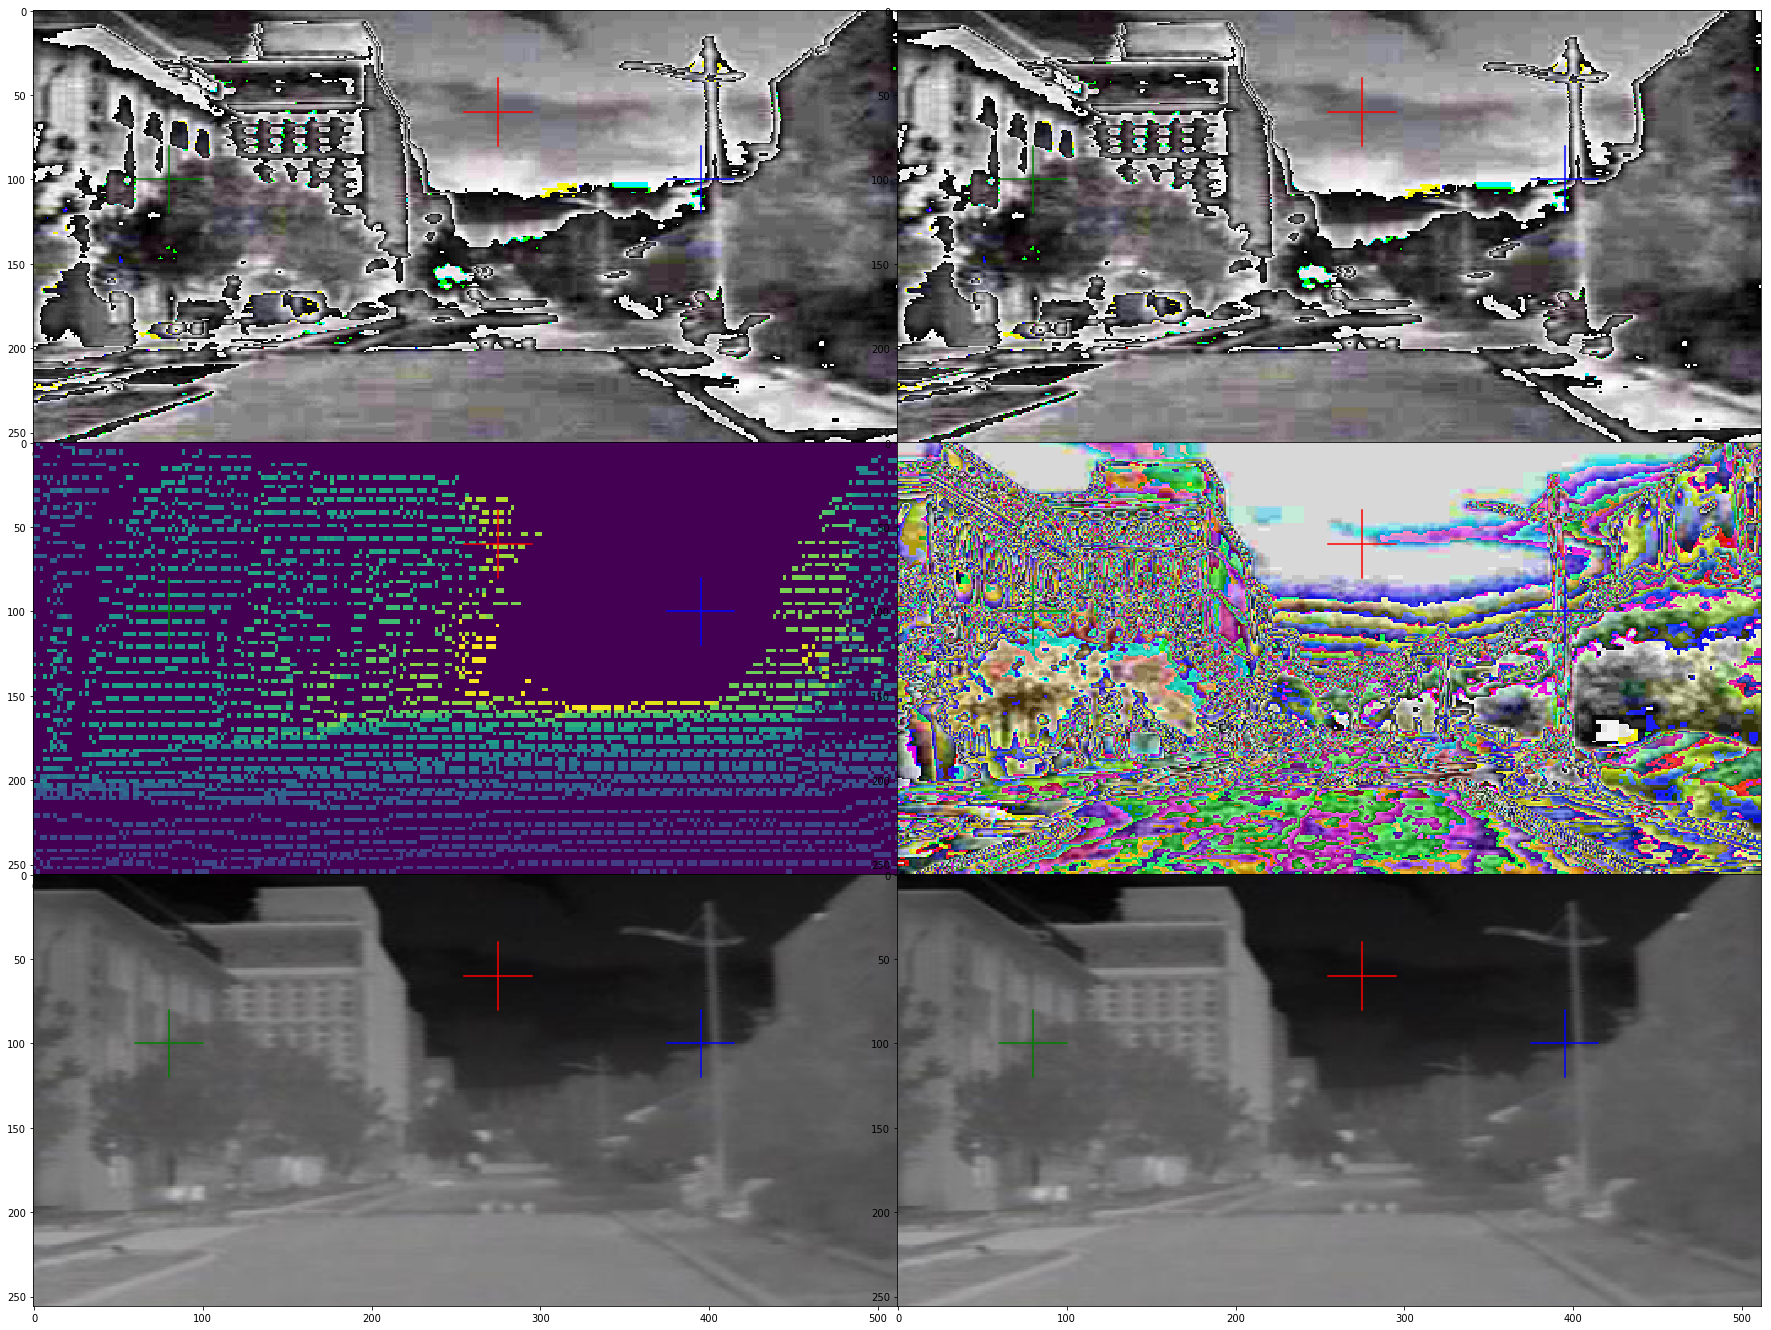

In [57]:
def paintpoint():
    paintXYaxes(60, 275, 'r', 20)
    paintXYaxes(100, 80, 'g', 20)
    paintXYaxes(100, 395, 'b', 20)

plt.figure(figsize=(60,30))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.5, top=0.8, hspace=0, wspace=0)

plt.subplot(321)   # ir
paintpoint()
plt.imshow(finished_ir*1.03)
plt.subplot(322)   # ir
paintpoint()
plt.imshow(finished_ir*1.03)

plt.subplot(323)   # depth
paintpoint()
plt.imshow(finished_depth)
plt.subplot(324)   # rgb
paintpoint()
plt.imshow(finished_rgb*20)

plt.subplot(325)   # ir
paintpoint()
plt.imshow(finished_ir)
plt.subplot(326)   # ir
paintpoint()
plt.imshow(finished_ir)

plt.show()

## 批处理数据

In [58]:
def HANDLE(ir_path, rgb_path, pc_path, save_ir_dir, save_rgb_dir, save_depth_dir, index):   # overall handling 
    for i in range(index[0],index[1]):                 # index 表示图片范围
        ir_name = os.path.split(ir_path[i])[1]
        save_ir_name = os.path.join(save_ir_dir, 'crop_'+ir_name)  
        
        rgb_name = os.path.split(rgb_path[i])[1]
        save_rgb_name = os.path.join(save_rgb_dir, 'crop_'+rgb_name)
        
        pc_name = os.path.split(pc_path[i])[1]
        depth_name = pc_name.split('.')[0][-7:] + '.jpg'
        save_depth_name = os.path.join(save_depth_dir, 'crop_'+depth_name)  # 'E:/.../crop_xxxxxxx.jpg'
        
        percentage = (i-index[0])/(index[1]-index[0]-1) * 100   # 进度条
        print("Handle the %4dth ternary: (%s) + (%s) + (%s)   %f%% " % (i, ir_name, rgb_name, pc_name, percentage))
        
        finished_ir, finished_rgb, finished_depth, _, _, _,_,_,_= final_depth(ir_path[i], rgb_path[i], pc_path[i])
        imsave(save_ir_name, finished_ir)
        imsave(save_rgb_name, finished_rgb)
        imsave(save_depth_name, finished_depth)
    print('Done.')

In [59]:
rgb_save_dir = 'D:/剪裁好的数据/2d_finish/'
ir_save_dir = 'D:/剪裁好的数据/ir_finish/'
depth_save_dir = 'D:/剪裁好的数据/depth_finish/'

In [157]:
HANDLE(ir_path, rgb_path, pc_path, ir_save_dir, rgb_save_dir, depth_save_dir, (117,150))    

Handle the  117th ternary: (ImageL0000100662.jpg) + (2D-00100662.jpg) + (3D64_0000100662.txt)   0.000000% 
Handle the  118th ternary: (ImageL0000100667.jpg) + (2D-00100667.jpg) + (3D64_0000100667.txt)   3.125000% 
Handle the  119th ternary: (ImageL0000100672.jpg) + (2D-00100672.jpg) + (3D64_0000100672.txt)   6.250000% 
Handle the  120th ternary: (ImageL0000100678.jpg) + (2D-00100678.jpg) + (3D64_0000100678.txt)   9.375000% 
Handle the  121th ternary: (ImageL0000100683.jpg) + (2D-00100683.jpg) + (3D64_0000100683.txt)   12.500000% 
Handle the  122th ternary: (ImageL0000100688.jpg) + (2D-00100688.jpg) + (3D64_0000100688.txt)   15.625000% 
Handle the  123th ternary: (ImageL0000100693.jpg) + (2D-00100693.jpg) + (3D64_0000100693.txt)   18.750000% 
Handle the  124th ternary: (ImageL0000100699.jpg) + (2D-00100699.jpg) + (3D64_0000100699.txt)   21.875000% 
Handle the  125th ternary: (ImageL0000100704.jpg) + (2D-00100704.jpg) + (3D64_0000100704.txt)   25.000000% 
Handle the  126th ternary: (Imag